In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

In [6]:
# Load the datasets (if not already loaded)
customers_df = pd.read_csv('Datasets/Customers.csv')
products_df = pd.read_csv('Datasets/Products.csv')
transactions_df = pd.read_csv('Datasets/Transactions.csv')

In [7]:
# Data Cleaning and Preprocessing (consistent with previous tasks)
customers_df.rename(columns={'CustomerID': 'CustomerID'}, inplace=True)
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
products_df.rename(columns={'ProductID': 'ProductID'}, inplace=True)
transactions_df.rename(columns={'TransactionID': 'TransactionID'}, inplace=True)
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
customers_df['SignupYear'] = customers_df['SignupDate'].dt.year
transactions_df['TransactionYear'] = transactions_df['TransactionDate'].dt.year

In [8]:
# Feature Engineering (reusing features from Lookalike model for consistency)
customer_profile_features = customers_df[['CustomerID', 'Region', 'SignupYear']].copy()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
region_encoded = encoder.fit_transform(customer_profile_features[['Region']])
region_feature_names = encoder.get_feature_names_out(['Region'])
region_df = pd.DataFrame(region_encoded, columns=region_feature_names, index=customer_profile_features.index)
customer_profile_features = pd.concat([customer_profile_features, region_df], axis=1).drop(['Region'], axis=1)

customer_transaction_features = transactions_df.groupby('CustomerID').agg(
    TransactionCount=('TransactionID', 'count'),
    TotalTransactionValue=('TotalValue', 'sum'),
    AvgQuantityPerTransaction=('Quantity', 'mean'),
    LastTransactionDate=('TransactionDate', 'max')
).reset_index()
ref_date = transactions_df['TransactionDate'].max() + pd.Timedelta(days=1)
customer_transaction_features['Recency'] = (ref_date - customer_transaction_features['LastTransactionDate']).dt.days
customer_transaction_features = customer_transaction_features.drop('LastTransactionDate', axis=1)

merged_transaction_product = pd.merge(transactions_df, products_df[['ProductID', 'Category']], on='ProductID', how='left')
category_pref_value = merged_transaction_product.groupby(['CustomerID', 'Category'])['TotalValue'].sum().unstack(fill_value=0)
category_pref_value.columns = [f"CategoryValue_{col}" for col in category_pref_value.columns]
category_pref_quantity = merged_transaction_product.groupby(['CustomerID', 'Category'])['Quantity'].sum().unstack(fill_value=0)
category_pref_quantity.columns = [f"CategoryQuantity_{col}" for col in category_pref_quantity.columns]

customer_category_features_value = category_pref_value.reset_index()
customer_category_features_quantity = category_pref_quantity.reset_index()

customer_features = pd.merge(customer_profile_features, customer_transaction_features, on='CustomerID', how='left').fillna(0)
customer_features = pd.merge(customer_features, customer_category_features_value, on='CustomerID', how='left').fillna(0)
customer_features = pd.merge(customer_features, customer_category_features_quantity, on='CustomerID', how='left').fillna(0)
customer_features.set_index('CustomerID', inplace=True)
customer_features = customer_features.drop('SignupYear', axis=1)



In [9]:
# Data Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)
scaled_customer_features_df = pd.DataFrame(scaled_features, index=customer_features.index, columns=customer_features.columns)

In [10]:
# --- Clustering using K-Means ---

# Range of clusters to try
cluster_range = range(2, 6) # Trying clusters from 2 to 5 (inclusive), you can extend up to 10

db_index_scores = []
silhouette_scores = []
ch_scores = []
kmeans_models = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # explicitly set n_init
    clusters = kmeans.fit_predict(scaled_customer_features_df)
    kmeans_models.append(kmeans)
    db_index = davies_bouldin_score(scaled_customer_features_df, clusters)
    silhouette_avg = silhouette_score(scaled_customer_features_df, clusters)
    ch_score = calinski_harabasz_score(scaled_customer_features_df, clusters)

    db_index_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    ch_scores.append(ch_score)

    print(f"For n_clusters = {n_clusters}:")
    print(f"  Davies-Bouldin Index: {db_index:.4f}")
    print(f"  Silhouette Score: {silhouette_avg:.4f}")
    print(f"  Calinski-Harabasz Index: {ch_score:.4f}")

For n_clusters = 2:
  Davies-Bouldin Index: 2.2141
  Silhouette Score: 0.1597
  Calinski-Harabasz Index: 37.3365
For n_clusters = 3:
  Davies-Bouldin Index: 2.1381
  Silhouette Score: 0.1415
  Calinski-Harabasz Index: 28.8488
For n_clusters = 4:
  Davies-Bouldin Index: 2.1000
  Silhouette Score: 0.1323
  Calinski-Harabasz Index: 26.7163
For n_clusters = 5:
  Davies-Bouldin Index: 1.7691
  Silhouette Score: 0.1811
  Calinski-Harabasz Index: 25.7705


In [11]:
# --- Evaluate and Choose Best Number of Clusters based on DB Index ---
best_clusters_index = np.argmin(db_index_scores) # Lower DB index is better
best_n_clusters = cluster_range[best_clusters_index]
best_kmeans_model = kmeans_models[best_clusters_index]
cluster_labels = best_kmeans_model.labels_
customer_clusters_df = pd.DataFrame({'CustomerID': scaled_customer_features_df.index, 'Cluster': cluster_labels})


print(f"\nOptimal number of clusters based on DB Index: {best_n_clusters}")
print(f"DB Index for optimal clusters: {db_index_scores[best_clusters_index]:.4f}")


Optimal number of clusters based on DB Index: 5
DB Index for optimal clusters: 1.7691


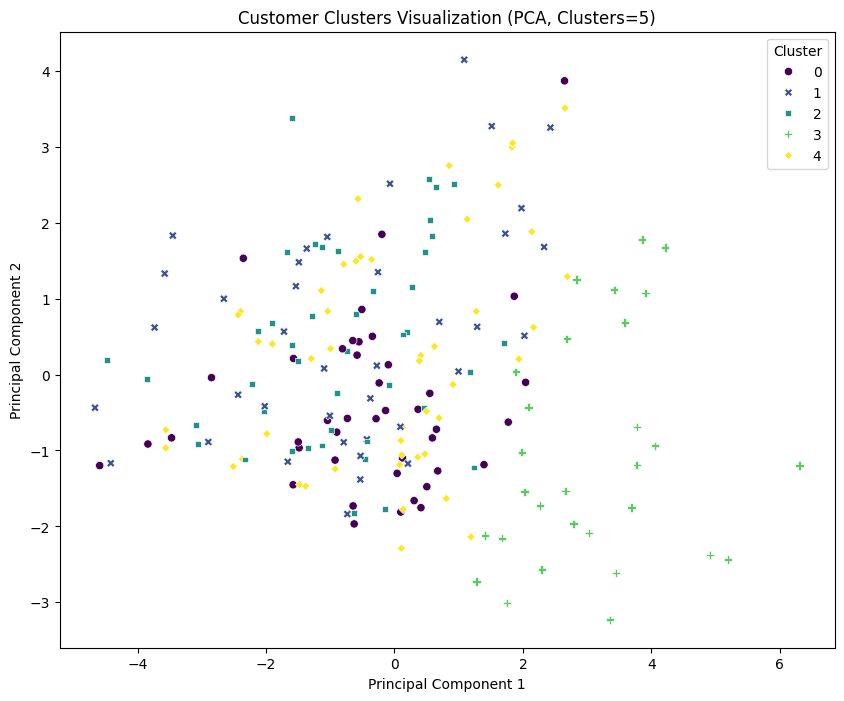

In [12]:
# --- Visualize Clusters using PCA ---
pca = PCA(n_components=2) # Reduce to 2 components for 2D visualization
principal_components = pca.fit_transform(scaled_customer_features_df)
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'], index=scaled_customer_features_df.index)
pca_df = pca_df.reset_index()
clustered_pca_df = pd.merge(pca_df, customer_clusters_df, on='CustomerID', how='left')


plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=clustered_pca_df, palette='viridis', style='Cluster', markers=True)
plt.title(f'Customer Clusters Visualization (PCA, Clusters={best_n_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [13]:
# --- Cluster Analysis and Report Generation ---
cluster_profiles = customer_clusters_df.groupby('Cluster')['CustomerID'].count()
print("\nCluster Sizes:")
print(cluster_profiles)

# Analyze cluster characteristics (e.g., average feature values per cluster - detailed profiling to be in report)
cluster_feature_means = customer_clusters_df.set_index('CustomerID').join(customer_features).groupby('Cluster').mean()
print("\nCluster Feature Means:")
print(cluster_feature_means)


print("\nTask 3 completed. Clustering analysis, metrics, and visualization generated.")
print("Cluster analysis report will be in PDF: Anshuk_Jirli_Clustering.pdf")


Cluster Sizes:
Cluster
0    42
1    38
2    43
3    29
4    48
Name: CustomerID, dtype: int64

Cluster Feature Means:
         Region_Asia  Region_Europe  Region_North America  \
Cluster                                                     
0           0.000000       0.000000              1.000000   
1           1.000000       0.000000              0.000000   
2           0.000000       1.000000              0.000000   
3           0.241379       0.241379              0.137931   
4           0.000000       0.000000              0.000000   

         Region_South America  TransactionCount  TotalTransactionValue  \
Cluster                                                                  
0                     0.00000          4.857143            2989.942381   
1                     0.00000          4.210526            2883.438684   
2                     0.00000          4.232558            2841.617209   
3                     0.37931          7.862069            6206.343103   
4        